In [17]:
import numpy as np

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import geocoder

import requests

!conda install -c conda-forge beautifulsoup4 --yes
from bs4 import BeautifulSoup

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print("Done")

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Done


# Coursera Capstone Final Project: Avo-cado Restaurant in Berlin

#### Create data frame with localities and coordinates

In [34]:
#Load data
data = requests.get("https://en.wikipedia.org/wiki/Category:Localities_of_Berlin").text

In [35]:
#Parse data with BeautifulSoup
soup = BeautifulSoup(data, 'html.parser')

In [36]:
#Create empty list
localitiesList = []

#Add localities to list 
for row in soup.find_all('div', class_='mw-category')[0].findAll('li')[1:]:
    localitiesList.append(row.text)

#Clean data
j=0
for item in localitiesList:
    localitiesList[j]= item.rstrip(' (Berlin)')
    j+=1

j=0 
for item in localitiesList:
    localitiesList[j]= item.rstrip(' (locality')
    j+=1
    
localitiesList

['Adlershof',
 'Alt-Hohenschönhaus',
 'Alt-Treptow',
 'Altglienick',
 'Baumschulenweg',
 'Biesdorf',
 'Blankenburg',
 'Blankenfeld',
 'Bohnsdorf',
 'Borsigwald',
 'Britz',
 'Buch',
 'Buckow',
 'Charlottenburg',
 'Charlottenburg-Nord',
 'Dahlem',
 'Falkenberg',
 'Falkenhagener Feld',
 'Fennpfuh',
 'Französisch Buchholz',
 'Friedenau',
 'Friedrichsfeld',
 'Friedrichshag',
 'Friedrichsh',
 'Frohnau',
 'Gatow',
 'Gesundbru',
 'Gropiusstad',
 'Grünau',
 'Grunewald',
 'Hakenfeld',
 'Halens',
 'Hansavier',
 'Haselhors',
 'Heiligens',
 'Heinersdorf',
 'Hellersdorf',
 'Hermsdorf',
 'Johannisth',
 'Karlshors',
 'Karow',
 'Kaulsdorf',
 'Kladow',
 'Konradshöh',
 'Köpenick',
 'Kreuzberg',
 'Lankwitz',
 'Lichtenberg',
 'Lichtenrad',
 'Lichterfeld',
 'Lübars',
 'Mahlsdorf',
 'Malchow',
 'Mariendorf',
 'Marienfeld',
 'Märkisches Vier',
 'Marzah',
 'Mitte',
 'Moab',
 'Müggelheim',
 'Neu-Hohenschönhaus',
 'Neukölln',
 'Niederschöneweid',
 'Niederschönhaus',
 'Nikolass',
 'Oberschöneweid',
 'Pankow',
 'P

In [37]:
#Create locality dataframe
berlin_df = pd.DataFrame({'Locality': localitiesList})

print(berlin_df.shape)
berlin_df.head()

(96, 1)


,Locality
0,Adlershof
1,Alt-Hohenschönhaus
2,Alt-Treptow
3,Altglienick
4,Baumschulenweg


In [21]:
#Create function to get coordinates
def get_latlng(locality):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Berlin, Germany'.format(locality))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [22]:
#Run function to get coordinates for localities
coords = [ get_latlng(locality) for locality in berlin_df['Locality'].tolist()]

In [26]:
#Create data frame of coordinates
coords_df = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
coords_df.head()

,Latitude,Longitude
0,52.43779,13.54778
1,52.54706,13.50055
2,52.49350,13.45711
3,52.42006,13.53969
4,52.46669,13.48840


In [38]:
#Merge dataframes
berlin_df['Latitude'] = coords_df['Latitude']
berlin_df['Longitude'] = coords_df['Longitude']

In [39]:
print(berlin_df.shape)
berlin_df.head()

(96, 3)


,Locality,Latitude,Longitude
0,Adlershof,52.43779,13.54778
1,Alt-Hohenschönhaus,52.54706,13.50055
2,Alt-Treptow,52.49350,13.45711
3,Altglienick,52.42006,13.53969
4,Baumschulenweg,52.46669,13.48840


In [40]:
#Save dataframe as CSV file
berlin_df.to_csv('berlin_df.csv', index=False)

### Create map with localities

In [42]:
#Get coordinates for Berlin, Germany
address = 'Berlin, Germany'

geolocator = Nominatim(user_agent='my-application')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of Berlin, Germany are {},{}.'.format(latitude, longitude))

The coordinates of Berlin, Germany are 52.5170365,13.3888599.


In [46]:
#Create map of Berlin, Germany
map_berlin = folium.Map(location=[latitude, longitude], zoom_start=11)

#Add localities to map
for lat, lng, locality in zip(berlin_df['Latitude'],berlin_df['Longitude'],berlin_df['Locality']):
    label = '{}'.format(locality)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_berlin)
    
map_berlin

In [50]:
#Save map as HTML file
map_berlin.save('map_berlin.html')

### Explore localities using Foursquare API

In [53]:
CLIENT_ID = '0N3DNNU34YQAFDV0XOUTDZ43QLI4FW34EDA3HFOCC5N0DJVX' # your Foursquare ID
CLIENT_SECRET = 'J3CU3TVRT1TFETDEUVCPGLMUBG33GAPTKEMUQEG24UGXLQ50' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentials:
CLIENT_ID: 0N3DNNU34YQAFDV0XOUTDZ43QLI4FW34EDA3HFOCC5N0DJVX
CLIENT_SECRET:J3CU3TVRT1TFETDEUVCPGLMUBG33GAPTKEMUQEG24UGXLQ50


In [59]:
#Get top 100 venues that are within a radius of 3000 meters
radius = 3000
LIMIT = 100

venues = []

for lat, long, locality in zip(berlin_df['Latitude'],berlin_df['Longitude'],berlin_df['Locality']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
    results = requests.get(url).json()['response']['groups'][0]['items']
    
    for venue in results:
        venues.append((
            locality,
            lat,
            long,
            venue['venue']['name'],
            venue['venue']['location']['lat'],
            venue['venue']['location']['lng'],
            venue['venue']['categories'][0]['name']))

In [70]:
#Convert venue data into a data frame
venues_df = pd.DataFrame(venues)

venues_df.columns=['Locality','Latitude','Longitude','VenueName','VenueLatitude','VenueLongitude','VenueCategory']

print(venues_df.shape)
venues_df.head()

(7170, 7)


,Locality,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Adlershof,52.43779,13.54778,Mia Toscana,52.438327,13.549573,Italian Restaurant
1,Adlershof,52.43779,13.54778,Griechisches Restaurant Athen,52.434901,13.546680,Greek Restaurant
2,Adlershof,52.43779,13.54778,McFIT,52.431000,13.549495,Gym / Fitness Center
3,Adlershof,52.43779,13.54778,Food - Taste of the world on the road,52.428786,13.538168,Food Truck
4,Adlershof,52.43779,13.54778,Schloss Köpenick,52.443679,13.572549,Palace


In [71]:
#Find unique categories
print('There are {} unique categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 321 unique categories.


### Identify areas that have restaurants as well as mexican restaurants

In [76]:
#Add one hot encoding
berlin_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix='',prefix_sep='')

berlin_onehot['Locality'] = venues_df['Locality']

fix_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fix_columns]

print(berlin_onehot.shape)
berlin_onehot.head()

(7170, 322)


,Locality,Adult Boutique,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bathing Area,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Canal,Candy Store,Capitol Building,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Rec Center,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Historic Site,History Museum,Hockey Field,Hockey Rink,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Kumpir Restaurant,Lake,Laser Tag,Laundromat,Laundry Service,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Nudist Beach,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Rugby Stadium,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Schnitzel Restaurant,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stables,Stadium,Stationery Store,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,

In [80]:
#Group rows by neighborhood
berlin_grouped = berlin_onehot.groupby(['Locality']).mean().reset_index()

print(berlin_grouped.shape)
berlin_grouped.head()

(96, 322)


,Locality,Adult Boutique,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bathing Area,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Canal,Candy Store,Capitol Building,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Rec Center,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Historic Site,History Museum,Hockey Field,Hockey Rink,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Kumpir Restaurant,Lake,Laser Tag,Laundromat,Laundry Service,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Nudist Beach,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Rugby Stadium,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Schnitzel Restaurant,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stables,Stadium,Stationery Store,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,

In [89]:
#Create data frame with Restaurant venue category
berlin_restaurant = berlin_grouped[['Locality','Restaurant','Mexican Restaurant']]
berlin_restaurant.head()

,Locality,Restaurant,Mexican Restaurant
0,Adlershof,0.010000,0.00
1,Alt-Hohenschönhaus,0.000000,0.00
2,Alt-Treptow,0.000000,0.01
3,Altglienick,0.022222,0.00
4,Baumschulenweg,0.000000,0.00


### Cluster localities

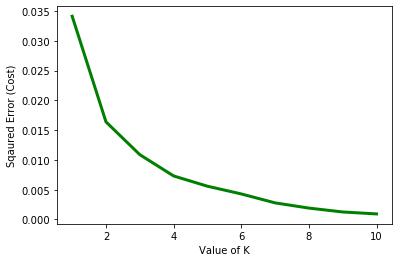

In [92]:
#Find optimal K for clustering
berlin_clustering = berlin_restaurant.drop(['Locality'],1)

cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(berlin_clustering) 
    
# calculates squared error 
# for the clustered points 
    cost.append(KM.inertia_)

import matplotlib.pyplot as plt
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

# the point of the elbow is the 
# most optimal value for choosing k

In [93]:
#Most optimal K=4. Now let's cluster localities
kclusters = 4

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_clustering)

kmeans.labels_[0:10]

array([0, 0, 0, 3, 0, 0, 3, 2, 0, 3], dtype=int32)

In [96]:
#Create data frame with clusters
berlin_merged = berlin_restaurant.copy()

berlin_merged['Cluster'] = kmeans.labels_
berlin_merged.head()

,Locality,Restaurant,Mexican Restaurant,Cluster
0,Adlershof,0.010000,0.00,0
1,Alt-Hohenschönhaus,0.000000,0.00,0
2,Alt-Treptow,0.000000,0.01,0
3,Altglienick,0.022222,0.00,3
4,Baumschulenweg,0.000000,0.00,0


In [98]:
#Add latitude and longitude to data frame
berlin_merged = berlin_merged.join(berlin_df.set_index('Locality'), on='Locality')

print(berlin_merged.shape)
berlin_merged.head()

(96, 6)


,Locality,Restaurant,Mexican Restaurant,Cluster,Latitude,Longitude
0,Adlershof,0.010000,0.00,0,52.43779,13.54778
1,Alt-Hohenschönhaus,0.000000,0.00,0,52.54706,13.50055
2,Alt-Treptow,0.000000,0.01,0,52.49350,13.45711
3,Altglienick,0.022222,0.00,3,52.42006,13.53969
4,Baumschulenweg,0.000000,0.00,0,52.46669,13.48840


In [100]:
#Visualize clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Locality'], berlin_merged['Cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [101]:
#Save map as HTML file
map_clusters.save('map_clusters.html')

### Examine clusters

##### Examine them together

In [111]:
#Group clusters by taking the mean of occurrence of each category
berlin_clusters_mean = berlin_merged.groupby(['Cluster']).mean()

berlin_clusters_mean

,Restaurant,Mexican Restaurant,Latitude,Longitude
Cluster,,,,
0,0.002988,0.001855,52.523811,13.393708
1,0.053982,0.000000,52.548920,13.242435
2,0.019075,0.030303,52.510153,13.406552
3,0.025796,0.001912,52.532572,13.345242


In [112]:
#Group clusters by taking the median of occurrence of each category
berlin_clusters_median = berlin_merged.groupby(['Cluster']).median()

berlin_clusters_median

,Restaurant,Mexican Restaurant,Latitude,Longitude
Cluster,,,,
0,0.000000,0.000000,52.510040,13.435410
1,0.050405,0.000000,52.555160,13.214570
2,0.021568,0.031754,52.503685,13.408045
3,0.025000,0.000000,52.558770,13.332830


##### Examine each cluster

In [113]:
berlin_merged.loc[berlin_merged['Cluster'] == 0]

,Locality,Restaurant,Mexican Restaurant,Cluster,Latitude,Longitude
0,Adlershof,0.010000,0.000000,0,52.437790,13.547780
1,Alt-Hohenschönhaus,0.000000,0.000000,0,52.547060,13.500550
2,Alt-Treptow,0.000000,0.010000,0,52.493500,13.457110
4,Baumschulenweg,0.000000,0.000000,0,52.466690,13.488400
5,Biesdorf,0.000000,0.000000,0,52.510040,13.553740
8,Bohnsdorf,0.000000,0.000000,0,52.401090,13.560570
11,Buch,0.000000,0.000000,0,52.634240,13.497530
13,Charlottenburg,0.010000,0.000000,0,52.519150,13.306390
14,Charlottenburg-Nord,0.000000,0.000000,0,52.530480,13.293710
15,Dahlem,0.010000,0.000000,0,52.458740,13.283440


In [114]:
berlin_merged.loc[berlin_merged['Cluster'] == 1]

,Locality,Restaurant,Mexican Restaurant,Cluster,Latitude,Longitude
42,Kladow,0.054054,0.0,1,52.45324,13.14345
43,Konradshöh,0.086957,0.0,1,52.58520,13.22698
50,Lübars,0.047619,0.0,1,52.62014,13.35525
70,Reinickendorf,0.040404,0.0,1,52.57545,13.34970
78,Spandau,0.041667,0.0,1,52.53487,13.20216
92,Wilhelmstad,0.053191,0.0,1,52.52462,13.17707


In [115]:
berlin_merged.loc[berlin_merged['Cluster'] == 2]

,Locality,Restaurant,Mexican Restaurant,Cluster,Latitude,Longitude
7,Blankenfeld,0.037037,0.037037,2,52.61855,13.39017
12,Buckow,0.028571,0.042857,2,52.42168,13.43099
19,Französisch Buchholz,0.000000,0.031250,2,52.60822,13.43368
24,Frohnau,0.035714,0.035714,2,52.63346,13.29038
27,Gropiusstad,0.022727,0.022727,2,52.42472,13.47370
48,Lichtenrad,0.000000,0.034483,2,52.39159,13.41247
54,Marienfeld,0.027778,0.027778,2,52.41262,13.36732
63,Niederschönhaus,0.000000,0.032258,2,52.58265,13.40362
72,Rudow,0.018519,0.018519,2,52.41917,13.49370
91,Wilhelmsruh,0.020408,0.020408,2,52.58887,13.36949


In [116]:
berlin_merged.loc[berlin_merged['Cluster'] == 3]

,Locality,Restaurant,Mexican Restaurant,Cluster,Latitude,Longitude
3,Altglienick,0.022222,0.0000,3,52.420060,13.539690
6,Blankenburg,0.025000,0.0000,3,52.593320,13.458050
9,Borsigwald,0.030000,0.0000,3,52.585220,13.307880
10,Britz,0.020000,0.0100,3,52.448730,13.436210
17,Falkenhagener Feld,0.027027,0.0000,3,52.551910,13.168020
30,Hakenfeld,0.032258,0.0000,3,52.558770,13.208310
33,Haselhors,0.026316,0.0000,3,52.543360,13.241520
34,Heiligens,0.037975,0.0000,3,52.583886,13.339850
37,Hermsdorf,0.033333,0.0000,3,52.614900,13.317830
52,Malchow,0.022727,0.0000,3,52.578480,13.483000
